In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

data = pd.read_csv('inningScore.csv') 
print(data.head())

print(data.columns)

  Team  1  2  3  4  5  6  7  8  9  ...  10  11  12  13  14  15  16  17  18  19
0  STL  0  0  0  0  0  0  0  0  1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
1  PIT  0  2  0  0  0  1  0  1  -  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  TOR  2  0  0  1  0  0  0  2  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3   TB  0  0  1  0  0  0  0  0  2  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NYM  0  0  0  0  0  0  0  3  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

[5 rows x 24 columns]
Index(['Team', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'R', 'H', 'E',
       'Game', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')


In [3]:
To_which_inning = 5

def Sum_to_n_inning(To_which_inning):  
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # print(sum_data.head(10))

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: abs(x.diff()))

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    # print(diff_data.head())

    plt.title(f'SumDiff to the end of Inning {To_which_inning}')
    sns.histplot(diff_data['SumDiff'], bins=20, kde=True)

## Plot the run difference to the end of inning 1-8

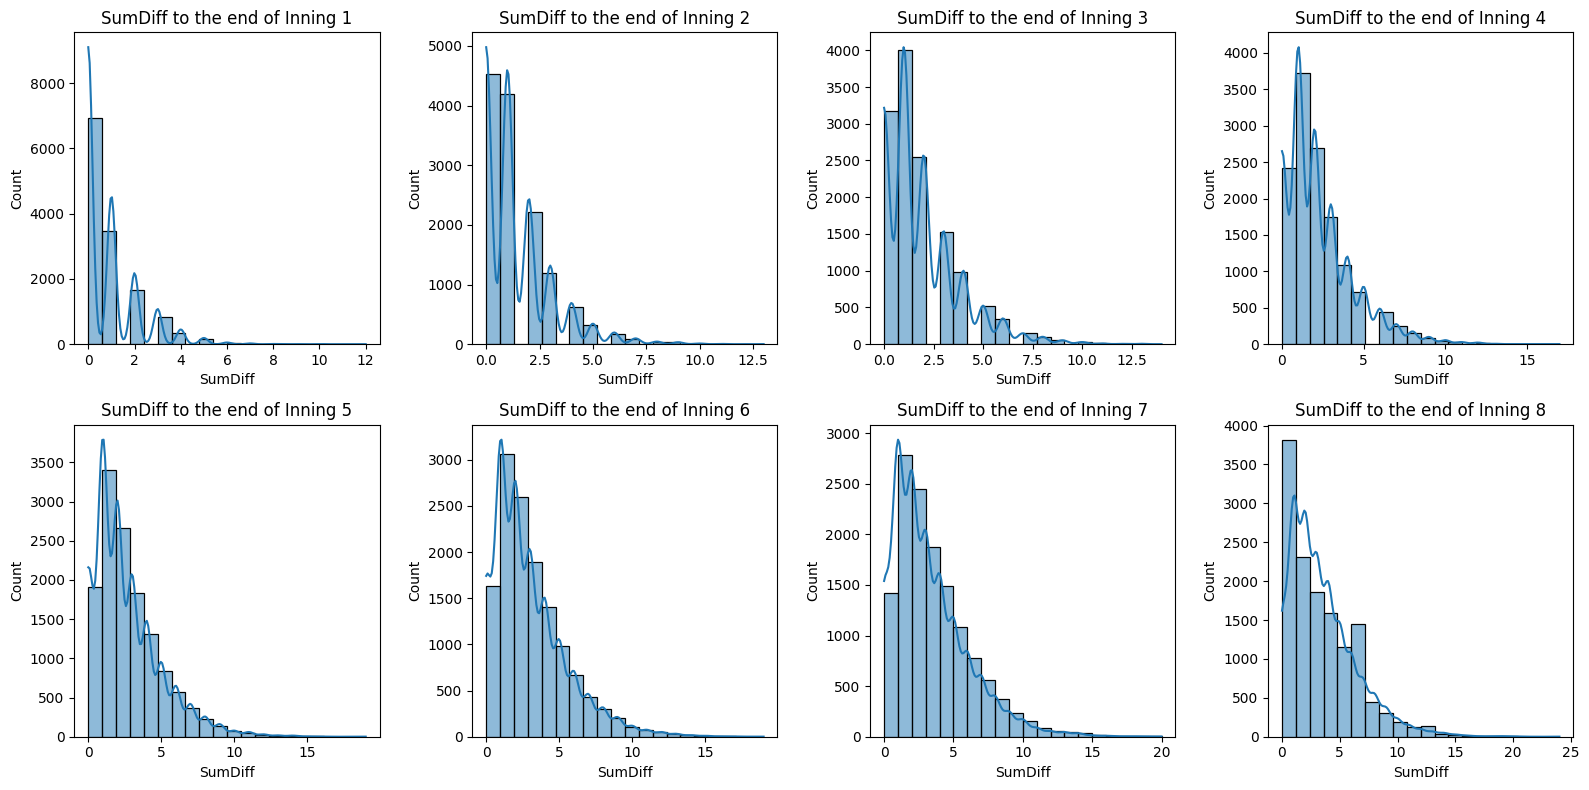

In [4]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

for i, ax in enumerate(axs.flat, start=1):
    plt.subplot(2, 4, i)  # Set current subplot
    Sum_to_n_inning(i)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Run difference at the End of the Game

ScoreDiff
 1.0     2200
-1.0     1489
 2.0     1245
-2.0     1152
 3.0      992
-3.0      949
 4.0      806
-4.0      762
-5.0      578
 5.0      574
 6.0      410
-6.0      406
 7.0      315
-7.0      306
 8.0      217
-8.0      193
 9.0      148
-9.0      142
 10.0      98
-10.0      95
-11.0      63
 11.0      60
 12.0      41
-12.0      35
 13.0      33
-13.0      32
 14.0      23
-14.0      17
-15.0      14
 15.0      10
 0.0        8
 16.0       8
-16.0       5
 18.0       4
 17.0       4
-18.0       3
-17.0       3
-19.0       2
 19.0       2
 21.0       2
 20.0       2
-20.0       1
-21.0       1
Name: count, dtype: int64


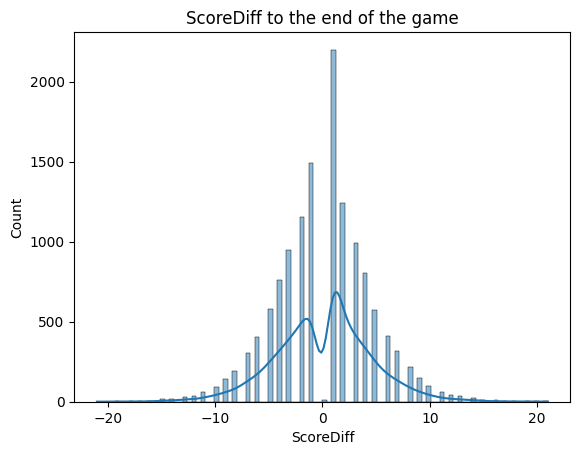

In [12]:
# sum elements in all_inning if it is not NaN
all_inning = [str(i) for i in range(1, 20)]
# print(all_inning)

data[all_inning] = data[all_inning].replace({np.nan: 0, '-': 0})

# Convert columns to numeric type
data[all_inning] = data[all_inning].apply(pd.to_numeric, errors='coerce')

data["final_score"] = data[all_inning].sum(axis=1, numeric_only=True)

# calculate the difference between the two teams per game
data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: x.diff())
# data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: abs(x.diff()))

# print(data.head())

ScoreDiff_data = data[['Game', 'ScoreDiff']].dropna()

print(ScoreDiff_data['ScoreDiff'].value_counts())

plt.title('ScoreDiff to the end of the game')
sns.histplot(ScoreDiff_data['ScoreDiff'], bins=100, kde=True)

plt.show()

In [11]:
'''
Preform normality test
'''

# scipy.stats.kstest(ScoreDiff_data['ScoreDiff'], 'norm')

scipy.stats.kstest(ScoreDiff_data['ScoreDiff'], 'norm',\
args=(ScoreDiff_data['ScoreDiff'].mean(), ScoreDiff_data['ScoreDiff'].std()))

scipy.stats.normaltest(ScoreDiff_data['ScoreDiff'])

NormaltestResult(statistic=176.16172056793997, pvalue=5.584295833289999e-39)

In [ ]:
'''
@TODO Try test for Poisson or Exponential (with abs(x.diff()))
'''